In [1]:
import time
import matplotlib.pyplot as plt

try:
    from lattice_field_mcmc import ScalarPhi4Model2D
except ModuleNotFoundError:
    !git clone https://github.com/ToelUl/Lattice-Field-MCMC-GPU.git
    !cp -r Lattice-Field-MCMC-GPU/lattice_field_mcmc ./
    from lattice_field_mcmc import ScalarPhi4Model2D

import torch
import numpy as np

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

✅ GPU runtime is enabled and ready!


In [2]:
L_size = 32
kappas = torch.linspace(0.22, 0.3, 64)
lambda_val = 0.02
chains = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

phi4_sampler = ScalarPhi4Model2D(
    L=L_size,
    kappa=kappas.to(device),
    lambda_=lambda_val,
    n_chains=chains,
    proposal_width=0.4,
    target_acceptance_rate=0.6,
    tune_interval=100,
    tuning_strength=0.2,
    device=device,
    use_amp=True,
    pt_enabled=True
)

start = time.time()
samples = phi4_sampler.forward(
    n_sweeps=3000,
    n_therm=10000,
    decorrelate=10,
    pt_interval=2
)
end = time.time()

print(f"Simulation complete. Sample tensor shape: {samples.shape}")
print(f"Elapsed time: {end - start:.2f} seconds")

Initialized ScalarLatticeSampler2D on device: cuda
 L=32, BatchSize=64, ChainsPerKappa=10, AMP=True, PT=True, LargeSim=False
Proposal width tuning enabled: target_rate=0.6, interval=100
Starting simulation: 10000 thermalization sweeps, 3000 production sweeps.
Proposal width tuning is ENABLED.
  [Tuning] Avg Acc Rate: 0.934 -> Avg Proposal Width: 0.427
  [Tuning] Avg Acc Rate: 0.939 -> Avg Proposal Width: 0.456
  [Tuning] Avg Acc Rate: 0.935 -> Avg Proposal Width: 0.486
  [Tuning] Avg Acc Rate: 0.930 -> Avg Proposal Width: 0.518
  [Tuning] Avg Acc Rate: 0.926 -> Avg Proposal Width: 0.552
  [Tuning] Avg Acc Rate: 0.921 -> Avg Proposal Width: 0.588
  [Tuning] Avg Acc Rate: 0.915 -> Avg Proposal Width: 0.625
  [Tuning] Avg Acc Rate: 0.910 -> Avg Proposal Width: 0.663
  [Tuning] Avg Acc Rate: 0.904 -> Avg Proposal Width: 0.704
  [Tuning] Avg Acc Rate: 0.898 -> Avg Proposal Width: 0.746
  [Tuning] Avg Acc Rate: 0.892 -> Avg Proposal Width: 0.789
  [Tuning] Avg Acc Rate: 0.885 -> Avg Proposal


Calculating observables and plotting results...


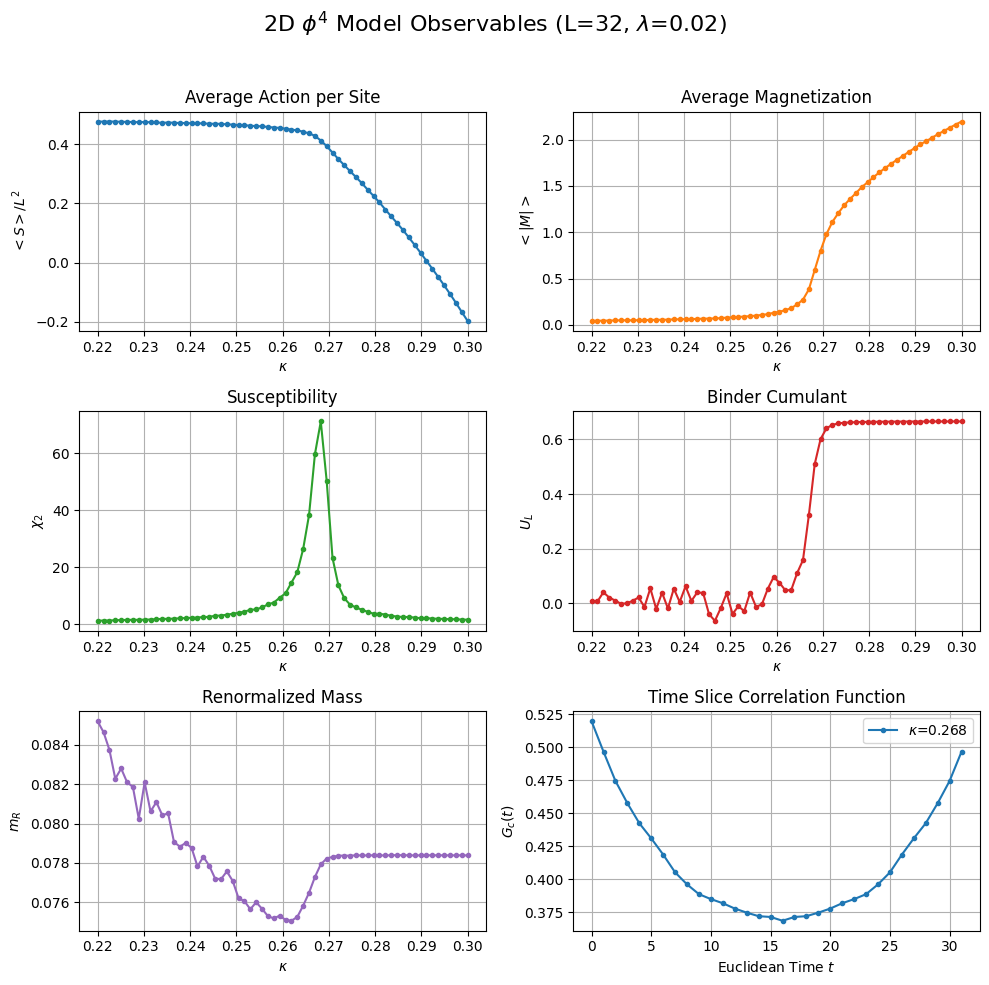

In [3]:
# =========================================================================
# Plotting Results
# =========================================================================
print("\nCalculating observables and plotting results...")

# Move samples and kappa to CPU for plotting
kappas_cpu = phi4_sampler.kappa.cpu().numpy()

# Calculate all observables
avg_action = phi4_sampler.compute_average_action(samples).cpu().numpy()
avg_mag = phi4_sampler.compute_average_magnetization(samples).cpu().numpy()
susceptibility = phi4_sampler.compute_susceptibility(samples).cpu().numpy()
binder = phi4_sampler.compute_binder_cumulant(samples).cpu().numpy()
renorm_mass = phi4_sampler.compute_renormalized_mass(samples).cpu().numpy()
rescaled_mass = phi4_sampler.compute_rescaled_renormalized_mass(samples).cpu().numpy()
time_corr = phi4_sampler.compute_time_slice_correlation(samples).cpu().numpy()

# Create a 4x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle(f'2D $\\phi^4$ Model Observables (L={L_size}, $\\lambda$={lambda_val})', fontsize=16)

# Plot 1: Average Action
axs[0, 0].plot(kappas_cpu, avg_action, 'o-', markersize=3)
axs[0, 0].set_title('Average Action per Site')
axs[0, 0].set_xlabel('$\\kappa$')
axs[0, 0].set_ylabel('$<S> / L^2$')
axs[0, 0].grid(True)

# Plot 2: Average Magnetization
axs[0, 1].plot(kappas_cpu, avg_mag, 'o-', markersize=3, color='tab:orange')
axs[0, 1].set_title('Average Magnetization')
axs[0, 1].set_xlabel('$\\kappa$')
axs[0, 1].set_ylabel('$<|M|>$')
axs[0, 1].grid(True)

# Plot 3: Susceptibility
axs[1, 0].plot(kappas_cpu, susceptibility, 'o-', markersize=3, color='tab:green')
axs[1, 0].set_title('Susceptibility')
axs[1, 0].set_xlabel('$\\kappa$')
axs[1, 0].set_ylabel('$\\chi_2$')
axs[1, 0].grid(True)

# Plot 4: Binder Cumulant
axs[1, 1].plot(kappas_cpu, binder, 'o-', markersize=3, color='tab:red')
axs[1, 1].set_title('Binder Cumulant')
axs[1, 1].set_xlabel('$\\kappa$')
axs[1, 1].set_ylabel('$U_L$')
axs[1, 1].grid(True)

# Plot 5: Renormalized Mass
axs[2, 0].plot(kappas_cpu, renorm_mass, 'o-', markersize=3, color='tab:purple')
axs[2, 0].set_title('Renormalized Mass')
axs[2, 0].set_xlabel('$\\kappa$')
axs[2, 0].set_ylabel('$m_R$')
axs[2, 0].grid(True)

# Plot 7: Time Slice Correlation
# Select a few representative kappa values to plot
num_kappas = len(kappas_cpu)
indices_to_plot = [
    # int(num_kappas * 0.1),  # Symmetric phase
    np.argmax(susceptibility), # Near critical point
    # int(num_kappas * 0.9)   # Broken phase
]

euclidean_time = np.arange(L_size)
for idx in indices_to_plot:
    kappa_val = kappas_cpu[idx]
    axs[2, 1].plot(
        euclidean_time,
        time_corr[idx],
        '.-',
        label=f'$\\kappa$={kappa_val:.3f}'
    )
axs[2, 1].set_title('Time Slice Correlation Function')
axs[2, 1].set_xlabel('Euclidean Time $t$')
axs[2, 1].set_ylabel('$G_c(t)$')
# axs[3, 0].set_yscale('log')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()